# Blockbusting in the 21st Century?: Minority Move-ins and Neighborhood Home Value Appreciation

## Introduction


I am using the [**Fannie Mae (FNMA) \& Freddie Mac (FHLMC)**](https://web.archive.org/web/20240914151448/https://www.fhfa.gov/data/single-family-census-tract-file) data to analyze the demographics of move-ins on a census-tract level. This, with the census-level demographic data **(ACS)**, can provide an estimate of a quantity of minority "move-ins". I am seeing the extent to which this has an effect on the appreciation in home values (**Zillow ZHVI**)

## Data Loading

We start by loading libraries. For dataframes we are using `pandas`, for plots we are using `pyplot` from `matplotlib`.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

Because the data is in ``.txt`` format, with no column headers, and is in many different files for different years and loan types, some light data cleaning is required. To begin, we set up short titles for each column based on the data dictionary provided, and then combine the Freddie and Fannie data into one dataframe for the year.

In [4]:
cols = [
    "enterprise_flag",
    "record_number",
    "state_code",
    "msa_code",
    "county_2020",
    "census_tract_2020",
    "tract_pct_minority",
    "tract_median_income",
    "local_median_income",
    "tract_income_ratio",
    "borrower_income",
    "borrower_income_missing",
    "borrower_housing_expense",
    "borrower_housing_expense_missing",
    "borrower_total_debt_expense",
    "borrower_total_debt_expense_missing",
    "borrower_credit_score",
    "borrower_credit_score_missing",
    "ltv_ratio",
    "cltv_ratio",
    "dti_ratio",
    "occupancy_status",
    "first_time_homebuyer",
    "loan_purpose",
    "property_type",
    "num_units",
    "num_units_missing",
    "affordable_units",
    "amortization_type",
    "loan_type",
    "lien_status",
    "channel",
    "property_valuation_method",
    "property_value",
    "property_value_missing",
    "interest_rate",
    "interest_rate_missing",
    "loan_term",
    "loan_term_missing",
    "prepayment_penalty",
    "prepayment_penalty_term",
    "prepayment_penalty_term_missing",
    "balloon_payment",
    "interest_only_payment",
    "negative_amortization",
    "property_state_code",
    "property_county_code",
    "property_census_tract",
    "property_zip_code",
    "property_street_address",
    "property_city",
    "property_state",
    "property_zip_plus4",
    "property_legal_description",
    "property_appraisal_date",
    "property_appraisal_date_missing",
    "property_appraisal_value",
    "property_appraisal_value_missing",
    "property_appraisal_method",
    "property_appraisal_method_missing",
    "property_appraisal_review_date",
    "property_appraisal_review_date_missing",
    "property_appraisal_review_value",
    "property_appraisal_review_value_missing"
]

In [5]:
fhlmc_sf2023 = pd.read_csv('data/sf/fhlmc_sf2023c_loans.txt', sep=r'\s+', header=None, names = cols)
fnma_sf2023 = pd.read_csv('data/sf/fnma_sf2023c_loans.txt', sep=r'\s+', header=None, names = cols)
loans_2023 = pd.concat([fhlmc_sf2023, fnma_sf2023])
loans_2023["year"] = 2023

fhlmc_sf2018 = pd.read_csv('data/sf/fhlmc_sf2018c_loans.txt', sep=r'\s+', header=None, names = cols)
fnma_sf2018 = pd.read_csv('data/sf/fnma_sf2018c_loans.txt', sep=r'\s+', header=None, names = cols)
loans_2018 = pd.concat([fhlmc_sf2018, fnma_sf2018])
loans_2018["year"] = 2018

loans = pd.concat([loans_2018, loans_2023])

In [11]:
loans = pd.DataFrame()
for year in range(2018, 2023):
    loans_year = pd.concat([
        pd.read_csv(f'data/sf/fhlmc_sf{year}c_loans.txt', sep=r'\s+', header=None, names=cols),
        pd.read_csv(f'data/sf/fnma_sf{year}c_loans.txt', sep=r'\s+', header=None, names=cols)])
    loans_year["year"] = year
    print(f'"{year} loaded"'),
    loans = pd.concat([loans, loans_year])
loans.head()

MemoryError: Unable to allocate 586. MiB for an array with shape (58, 1323883) and data type int64

In addition, we want to have some dictionaries to decode data. For example, in the `loans` dataframe, each metropolitan area is given by its "MSA code", which means nothing to us. Rather, we want to know the MSA name.

In [10]:
msa_codes = pd.read_csv('data/MSA_2023.txt', sep='\s+=\s+', header=None, engine='python', names=['msa_code', 'msa_name'])
loans = loans.merge(msa_codes, on='msa_code', how='left')

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\emers\AppData\Local\Temp\ipykernel_65404\454297998.py:1: SyntaxWarning: invalid escape sequence '\s'
  msa_codes = pd.read_csv('data/MSA_2023.txt', sep='\s+=\s+', header=None, engine='python', names=['msa_code', 'msa_name'])


## Summary Statistics

One potentially interesting summary statistic is the quantity of loans in 2023 in each metropolitan area. We use ``groupby`` to look at each individual MSA and the count of entries in the table for each to define ``vol_by_msa`` which is the loan volume in each MSA.

In [6]:
mf_loans_2023[["pct_minority", "median_inc_tract", "LTV","num_of_units","note_amt","int_rate"]].describe()

,pct_minority,median_inc_tract,LTV,num_of_units,note_amt,int_rate
count,5468.000000,5468.000000,5468.000000,5468.000000,5.468000e+03,5468.000000
mean,53.414276,95970.101500,61.425642,3.818581,2.407242e+07,5.975040
std,26.730757,121930.260639,37.455017,1.901836,5.507027e+07,3.650544
min,4.770000,2499.000000,1.900000,1.000000,3.150000e+05,0.840000
25%,30.427500,53063.500000,54.467500,2.000000,4.222500e+06,5.340000
50%,50.790000,73061.000000,61.400000,4.000000,1.194000e+07,5.750000
75%,76.700000,101589.750000,65.600000,5.000000,3.052750e+07,6.270000
max,99.860000,999999.000000,999.000000,9.000000,1.000000e+09,99.000000


## Plots \& Figures

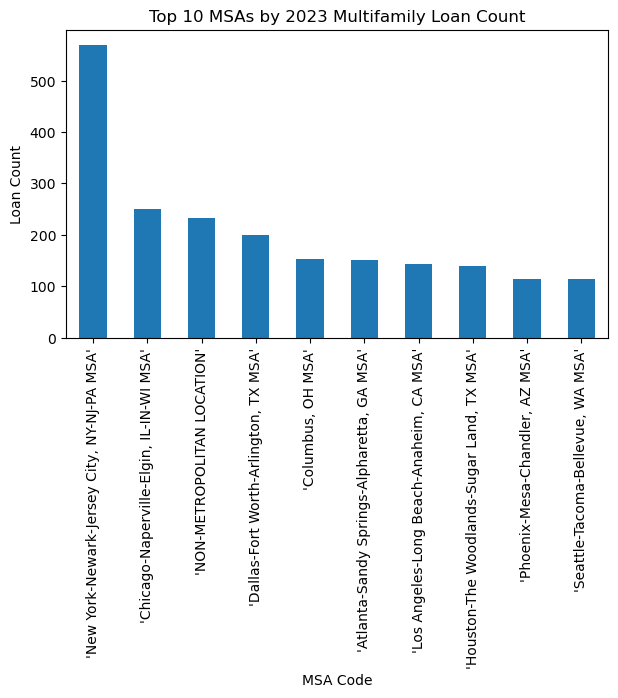

In [12]:
vol_by_msa.head(10).plot(kind='bar', figsize=(7, 4))
plt.title('Top 10 MSAs by 2023 Multifamily Loan Count')
plt.xlabel('MSA Code')
plt.ylabel('Loan Count')
plt.show()

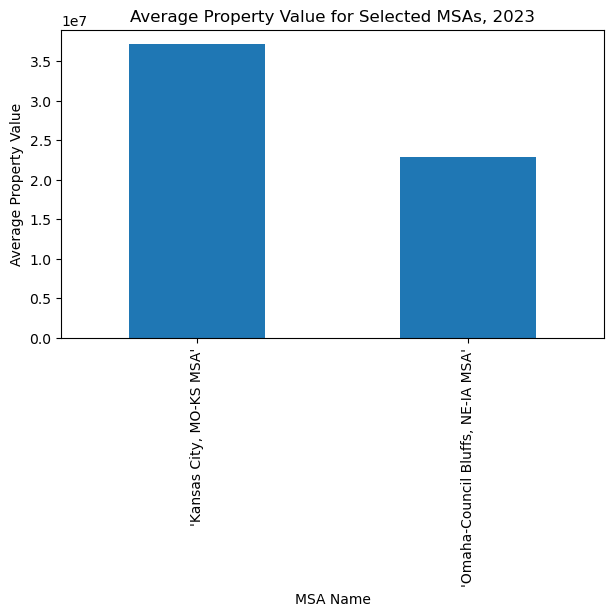

In [19]:
msa_filtered = mf_loans_2023[mf_loans_2023['msa_name'].isin(["'Omaha-Council Bluffs, NE-IA MSA'", "'Kansas City, MO-KS MSA'"])]
msa_filtered.groupby('msa_name')["prop_val"].mean().sort_values(ascending=False).plot(kind='bar', figsize=(7, 4))
plt.title('Average Multifamily Property Value for Selected MSAs, 2023')
plt.xlabel('MSA Name')
plt.ylabel('Average Property Value')
plt.show()

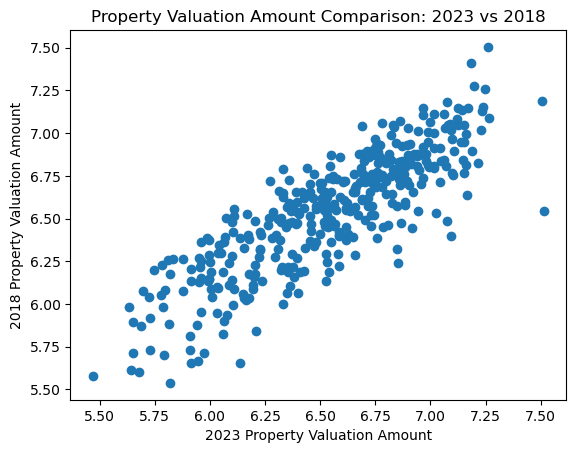

In [15]:
msas_2023_values = sf_loans_2023.groupby('Metropolitan Statistical Area (MSA) Code')["Property Valuation Amount"].mean().sort_values(ascending=False)
msas_2018_values = sf_loans_2018.groupby('Metropolitan Statistical Area (MSA) Code')["Property Valuation Amount"].mean().sort_values(ascending=False)
msa_values_by_year = pd.concat([msas_2023_values, msas_2018_values], axis=1)
msa_values_by_year.columns = ['2023', '2018']
plt.scatter(msa_values_by_year['2023'], msa_values_by_year['2018'])
plt.xlabel('2023 Property Valuation Amount')
plt.ylabel('2018 Property Valuation Amount')
plt.title('Property Valuation Amount Comparison: 2023 vs 2018')
plt.show()

Text(0, 0.5, 'Count')

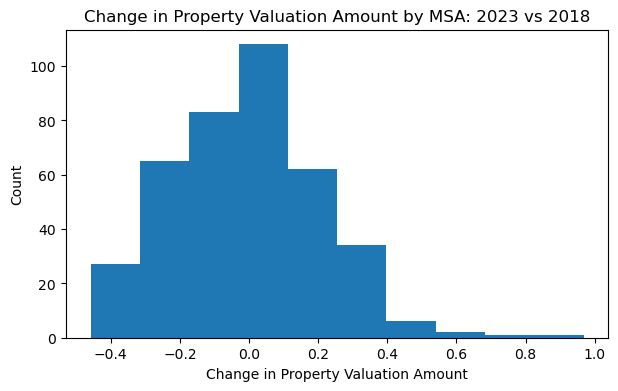

In [22]:
msa_value_change = msa_values_by_year['2023'] - msa_values_by_year['2018']
msa_value_change.sort_values(ascending=False).plot(kind='hist', figsize=(7, 4))
plt.title('Change in Property Valuation Amount by MSA: 2023 vs 2018')
plt.xlabel('Change in Property Valuation Amount')
plt.ylabel('Count')

## Conclusion